## Goal of this notebook

In this notebook, i will attempt to fit a geodesic in the space of curves using the $F_{ab}$ function in http://arxiv.org/abs/1803.10894. This function gives us the ability to take a curve (for example, the outline of a cell shape) in the "space of curves" and transform it to "q-space". This is advantageous for us because "q-space" is a two dimensional flat euclidean space. Thus, if we transform the data into q space, then we can fit that data using a line (which is a geodesic in q space). If we want to make predictions about future data points in the "space of curves" then we can extrapolate the data in "q-space" using the line, and then we can transform that extrapolated data back into the "space of curves" using the inverse F transform. 

This is how we will fit/extrapolate data in this notebook. I will fit both synthetic and real datasets. 

## Metric used: Elastic Metric

I will be using the elastic metric to perform calculations on the "space of curves" (a manifold). The elastic metric is a good choice of metric for "curve space" analysis for several reasons:

1. It separates points on a manifold based on the amount of "bending/rigidity" or "stretching/tension" that exists between two curves. This provides a method of separating/placing curves on the manifold which is intuitive (intuitive is always good).
2. The elastic metric has two parameters: the "bending" parameter $b$ and the "stretching" parameter $a$. These parameters can be easily changed to tweak the metric.  When $a$ is large, then two curves that differ by a stretching operation will be far apart. When $b$ is large, two curves that differ by a bending operation wil be far apart.

I will repeat analysis for the synthetic and real datasets for several different elastic metric parameters $a$ and $b$.

# Note:

All of the functions in this notebook have been consolidated into a .py file: f_fit_functions.py. I am keeping this notebook as a "tutorial" for how those functions were developed because this notebook nicely highlights and explains the important steps in f_fit_functions.py.

# Begin dataset analysis:

In [247]:
#first, load relevant things:

import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

#load discrete curves and R2 manifolds
from geomstats.geometry.discrete_curves import DiscreteCurves, R2

#specify the manifold that we are working on and give that manifold a metric (elastic metric)
#note that a and b are the parameters that we edit.
SPACE = DiscreteCurves(R2, a=1, b=1)
METRIC = SPACE.elastic_metric

# 1. Synthetic Datasets

In [248]:
#import synthetic datasets

import dyn.dyn.datasets.synthetic as synthetic

n_geodesics = 1
n_times = 10
n_points = 40

#creating our synthetic dataset
geods_square_rect = synthetic.geodesics_square_to_rectangle(
    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
)

## 1.1 getting familiar with the dataset array

In [249]:
# From synthetic.py: 
#geodesics = gs.zeros((n_geodesics, n_times, n_points, dim))
#n_geodesics is the number of geodesics we want to calculate
#n_times is the number of times (or rather, the shape at that time) we want to "sample" on each geodesic
#n_points is the number of points on the curve.
#dim is the dimension of the curve. (for example, a 2D curve has dim=2)

print(geods_square_rect.shape)

torch.Size([1, 10, 40, 2])


In [250]:
#printing the first geodesic at the first time. this is the list of all of the coordinates of each point on the curve.

print(geods_square_rect[0,0,:,:])

tensor([[-1.0451e+00, -1.0451e+00],
        [-8.3605e-01, -1.0451e+00],
        [-6.2704e-01, -1.0451e+00],
        [-4.1802e-01, -1.0451e+00],
        [-2.0901e-01, -1.0451e+00],
        [ 2.9802e-08, -1.0451e+00],
        [ 2.0901e-01, -1.0451e+00],
        [ 4.1802e-01, -1.0451e+00],
        [ 6.2704e-01, -1.0451e+00],
        [ 8.3605e-01, -1.0451e+00],
        [ 1.0451e+00, -1.0451e+00],
        [ 1.0451e+00, -8.3605e-01],
        [ 1.0451e+00, -6.2704e-01],
        [ 1.0451e+00, -4.1802e-01],
        [ 1.0451e+00, -2.0901e-01],
        [ 1.0451e+00,  2.9802e-08],
        [ 1.0451e+00,  2.0901e-01],
        [ 1.0451e+00,  4.1802e-01],
        [ 1.0451e+00,  6.2704e-01],
        [ 1.0451e+00,  8.3605e-01],
        [ 1.0451e+00,  1.0451e+00],
        [ 8.3605e-01,  1.0451e+00],
        [ 6.2704e-01,  1.0451e+00],
        [ 4.1802e-01,  1.0451e+00],
        [ 2.0901e-01,  1.0451e+00],
        [ 2.9802e-08,  1.0451e+00],
        [-2.0901e-01,  1.0451e+00],
        [-4.1802e-01,  1.045

In [251]:
from matplotlib import pyplot as plt

In [252]:
data =  geods_square_rect[0,0,:,:].numpy()
print(data.shape)

(40, 2)


In [253]:
geods_square_rect[0,0,:,0]

tensor([-1.0451e+00, -8.3605e-01, -6.2704e-01, -4.1802e-01, -2.0901e-01,
         2.9802e-08,  2.0901e-01,  4.1802e-01,  6.2704e-01,  8.3605e-01,
         1.0451e+00,  1.0451e+00,  1.0451e+00,  1.0451e+00,  1.0451e+00,
         1.0451e+00,  1.0451e+00,  1.0451e+00,  1.0451e+00,  1.0451e+00,
         1.0451e+00,  8.3605e-01,  6.2704e-01,  4.1802e-01,  2.0901e-01,
         2.9802e-08, -2.0901e-01, -4.1802e-01, -6.2704e-01, -8.3605e-01,
        -1.0451e+00, -1.0451e+00, -1.0451e+00, -1.0451e+00, -1.0451e+00,
        -1.0451e+00, -1.0451e+00, -1.0451e+00, -1.0451e+00, -1.0451e+00])

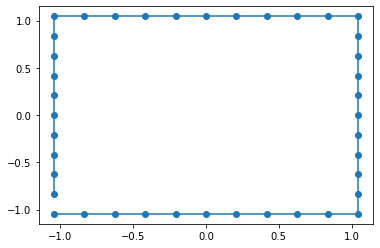

In [254]:
#how to plot the square
plt.plot(geods_square_rect[0,0,:,0], geods_square_rect[0,0,:,1],marker="o")

## 1.2 Transform the dataset of curves (c1,..., cT) into their corresponding "q's" using `f_transform`.

In [255]:
#first, we must import the elastic metric class because that is where the f transform is located
from geomstats.geometry.discrete_curves import ElasticMetric
import numpy as np

# this is creating (aka "instantiating") an object elastic_metric of the class ElasticMetric
elastic_metric = ElasticMetric(a=1, b=1, ambient_manifold=R2)  

#selecting the first (and only) geodesic
#geodesic = geods_square_rect[0]

q_tensor = elastic_metric.f_transform(geods_square_rect[0])

"""
#this is the longer version of the line above:

#this creates a list of q tensors
q_tensor_list=[]

for i_time in range(n_times):
    #selecting the shape at a single "time" in the geodesic
    #curve= geodesic[i_time]
    curve= geods_square_rect[0,i_time,:,:]
    #print(curve)
    #must keep curve as a tensor for now becaue that is what f_transform expects
    q_tensor_list.append(elastic_metric.f_transform(curve))
    #print(elastic_metric.f_transform(curve))

#at this point, q_tensor_list is a list of transformed tensors.
#we want to convert the tensors into arrays, which we can deal with more easily
q_list=[]
for i_time in range(n_times):
    q_list.append(np.array(q_tensor_list[i_time]))

#now, we want to convert the list of arrays into an array of arrays (3D array)
q=np.array(q_list)

#look, it worked. Note that this dimension is correct.
#the number of points should go from 40 -> 39 because in f_transform, we calculate the 
#"velocity" which has to do with the space between points, and q is related to this velcity.

"""
q=np.array(q_tensor)
print(q)

[[[ 5.7101555e+00  0.0000000e+00]
  [ 5.7101555e+00  0.0000000e+00]
  [ 5.7101574e+00  0.0000000e+00]
  [ 5.7101560e+00  0.0000000e+00]
  [ 5.7101560e+00  0.0000000e+00]
  [ 5.7101560e+00  0.0000000e+00]
  [ 5.7101560e+00  0.0000000e+00]
  [ 5.7101564e+00  0.0000000e+00]
  [ 5.7101564e+00  0.0000000e+00]
  [ 5.7101564e+00  0.0000000e+00]
  [ 4.0376897e+00  4.0376897e+00]
  [ 4.0376897e+00  4.0376897e+00]
  [ 4.0376911e+00  4.0376911e+00]
  [ 4.0376902e+00  4.0376902e+00]
  [ 4.0376902e+00  4.0376902e+00]
  [ 4.0376902e+00  4.0376902e+00]
  [ 4.0376902e+00  4.0376902e+00]
  [ 4.0376902e+00  4.0376902e+00]
  [ 4.0376902e+00  4.0376902e+00]
  [ 4.0376902e+00  4.0376902e+00]
  [-2.4959886e-07  5.7101564e+00]
  [-2.4959886e-07  5.7101564e+00]
  [-2.4959886e-07  5.7101564e+00]
  [-2.4959886e-07  5.7101560e+00]
  [-2.4959886e-07  5.7101560e+00]
  [-2.4959886e-07  5.7101560e+00]
  [-2.4959886e-07  5.7101560e+00]
  [-2.4959891e-07  5.7101574e+00]
  [-2.4959883e-07  5.7101555e+00]
  [-2.4959883e

## 1.3 Now, fit q1, …, qT with linear regression

In [256]:
#in order to do linear regression with the q's, we will have to re-shape q because linear regression expects
#something with a 1D shape. Therefore, we will create q_vector. 
#https://www.adamsmith.haus/python/answers/how-to-reshape-a-numpy-array-into-a-vector-in-python


"""
#we want to turn each of q1,...qT into a 1D array.
q_vector_list =[]
for i_times in range(n_times):
    q_vector_list.append(np.reshape(q[i_times], -1))
                         
                         
q_vector=np.array(q_vector_list)

"""

#this is much more efficient than the code above.
#reshape q into a compressed vector
q_vector = q.reshape((n_times, -1))

#now, q_vector is a 2D array where the first column is times and the second column is a bunch of numbers
print(q_vector.shape)
#print(q_vector)

(10, 78)


In [257]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

#create regression object
regr = linear_model.LinearRegression()

#Now, i need to create an array that only has the times
q_times_1d = gs.arange(0, n_times, 1)
q_times = np.reshape(q_times_1d,(10,1))

"""
#this is wrong
q_times_list= []
for i_time in range(n_times):
    q_times_list.append([q_vector[i_time,0]])
q_times=np.array(q_times_list)
"""
print(q_times.shape)

regr.fit(q_times,q_vector)

torch.Size([10, 1])


LinearRegression()

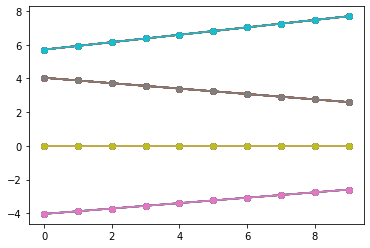

In [258]:
plt.plot( q_vector, marker = 'o')

## 1.4 Compute the estimated_q1, …., estimated_qT corresponding to the q1, …, qT

In [259]:
#compute estimated q predictions
q_vector_predict=regr.predict(q_times)
print(q_vector_predict)

[[ 5.71015589e+00  0.00000000e+00  5.71015602e+00  0.00000000e+00
   5.71015713e+00  0.00000000e+00  5.71015607e+00  0.00000000e+00
   5.71015607e+00  0.00000000e+00  5.71015610e+00  0.00000000e+00
   5.71015590e+00  0.00000000e+00  5.71015688e+00  0.00000000e+00
   5.71015616e+00  0.00000000e+00  5.71015646e+00  0.00000000e+00
   4.03768975e+00  4.03768975e+00  4.03768986e+00  4.03768986e+00
   4.03769068e+00  4.03769068e+00  4.03768988e+00  4.03768988e+00
   4.03768986e+00  4.03768986e+00  4.03768986e+00  4.03768986e+00
   4.03768997e+00  4.03768997e+00  4.03769060e+00  4.03769060e+00
   4.03768998e+00  4.03768998e+00  4.03769011e+00  4.03769011e+00
  -2.49598859e-07  5.71015646e+00 -2.49598850e-07  5.71015616e+00
  -2.49598876e-07  5.71015688e+00 -2.49598842e-07  5.71015590e+00
  -2.49598852e-07  5.71015610e+00 -2.49598850e-07  5.71015607e+00
  -2.49598850e-07  5.71015607e+00 -2.49598895e-07  5.71015713e+00
  -2.49598850e-07  5.71015602e+00 -2.49598840e-07  5.71015589e+00
  -4.03769

## 1.5 Inverse transform estimated_q1, …, estimated_qT into curves

In [260]:

#first, we will have to de-compress the vector (turn it back into its original shape)
print(q_vector_predict.shape)
q_array_predict = np.reshape(q_vector_predict,(n_times,n_points-1,2))
print(q_array_predict.shape)

#now, we will transform the array back into a tensor so that f_transoform_inverse will accept it
import torch

q_tensor_predict= torch.from_numpy(q_array_predict)


(10, 78)
(10, 39, 2)


In [93]:
"""

#first, we will have to de-compress the vector (turn it back into its original shape)
print(q_vector_predict.shape)
q_array_predict = np.reshape(q_vector_predict,(n_times,n_points-1,2))
print(q_array_predict.shape)

#now, we will transform the array back into a tensor so that f_transoform_inverse will accept it
import torch

q_tensor_predict= []
#specifically, we want each of the arrays at i_time to be tensors.
for i_time in range(n_times):
    q_tensor_predict.append(torch.from_numpy(q_array_predict[i_time])) 
#print(q_tensor_predict)
"""

'\n\n#first, we will have to de-compress the vector (turn it back into its original shape)\nprint(q_vector_predict.shape)\nq_array_predict = np.reshape(q_vector_predict,(n_times,n_points-1,2))\nprint(q_array_predict.shape)\n\n#now, we will transform the array back into a tensor so that f_transoform_inverse will accept it\nimport torch\n\nq_tensor_predict= []\n#specifically, we want each of the arrays at i_time to be tensors.\nfor i_time in range(n_times):\n    q_tensor_predict.append(torch.from_numpy(q_array_predict[i_time])) \n#print(q_tensor_predict)\n'

In [262]:
starting_point = gs.array([0., 0.])
starting_point_array = gs.zeros((n_times, 2))

predicted_curves=elastic_metric.f_transform_inverse(q_tensor_predict,starting_point_array)
print(predicted_curves)

tensor([[[ 0.0000e+00,  0.0000e+00],
         [ 2.0901e-01,  0.0000e+00],
         [ 4.1802e-01,  0.0000e+00],
         [ 6.2704e-01,  0.0000e+00],
         [ 8.3605e-01,  0.0000e+00],
         [ 1.0451e+00,  0.0000e+00],
         [ 1.2541e+00,  0.0000e+00],
         [ 1.4631e+00,  0.0000e+00],
         [ 1.6721e+00,  0.0000e+00],
         [ 1.8811e+00,  0.0000e+00],
         [ 2.0901e+00,  0.0000e+00],
         [ 2.0901e+00,  2.0901e-01],
         [ 2.0901e+00,  4.1802e-01],
         [ 2.0901e+00,  6.2704e-01],
         [ 2.0901e+00,  8.3605e-01],
         [ 2.0901e+00,  1.0451e+00],
         [ 2.0901e+00,  1.2541e+00],
         [ 2.0901e+00,  1.4631e+00],
         [ 2.0901e+00,  1.6721e+00],
         [ 2.0901e+00,  1.8811e+00],
         [ 2.0901e+00,  2.0901e+00],
         [ 1.8811e+00,  2.0901e+00],
         [ 1.6721e+00,  2.0901e+00],
         [ 1.4631e+00,  2.0901e+00],
         [ 1.2541e+00,  2.0901e+00],
         [ 1.0451e+00,  2.0901e+00],
         [ 8.3605e-01,  2.0901e+00],
 

In [263]:
"""
curve_predicted_list=[]
for i_time in range(n_times):
    tensor_form=elastic_metric.f_transform_inverse(q_tensor_predict[i_time,:,:],starting_point)
    array_form=np.array(tensor_form)
    curve_predicted_list.append(array_form)
curve_predicted=np.array(curve_predicted_list)
curve_predicted_tensor = torch.from_numpy(curve_predicted)
print(curve_predicted_tensor)
"""

'\ncurve_predicted_list=[]\nfor i_time in range(n_times):\n    tensor_form=elastic_metric.f_transform_inverse(q_tensor_predict[i_time,:,:],starting_point)\n    array_form=np.array(tensor_form)\n    curve_predicted_list.append(array_form)\ncurve_predicted=np.array(curve_predicted_list)\ncurve_predicted_tensor = torch.from_numpy(curve_predicted)\nprint(curve_predicted_tensor)\n'

## 1.6 See whether predicted curves are close to original curves

In [264]:
#first, i will create a new array, where one of the geodesics is the original geodesic and the other geodesic
#is the predicted geodesic.

geodesic_array= np.array([geods_square_rect[0],predicted_curves])

/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_764/4214073001.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([geods_square_rect[0],predicted_curves])
/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_764/4214073001.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([geods_square_rect[0],pre

now, i will use code from "explore synthetic datasets" to plot them

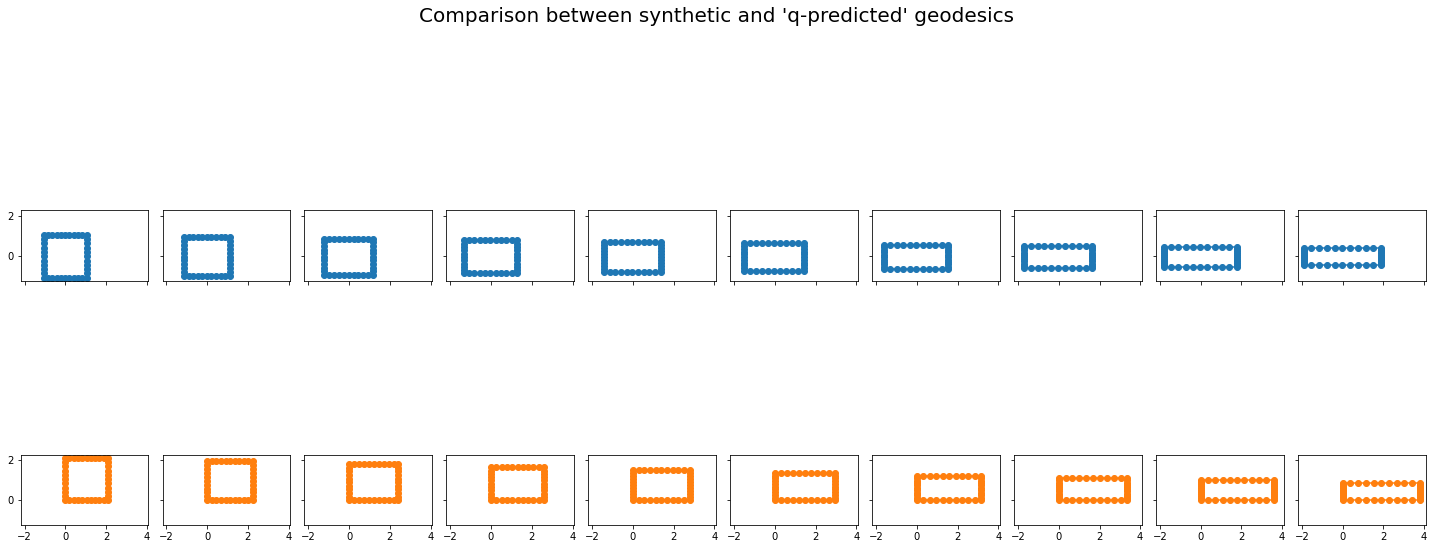

In [265]:
import matplotlib.pyplot as plt

n_geodesics=2
fig, axes = plt.subplots(
    n_geodesics, n_times, figsize=(20, 10), sharex=True, sharey=True
)
fig.suptitle("Comparison between synthetic and 'q-predicted' geodesics", fontsize=20)

for i_geodesic in range(n_geodesics):
    curve = geodesic_array[i_geodesic]
    for i_time in range(n_times):
        axes[i_geodesic, i_time].plot(
            curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
        )
        axes[i_geodesic, i_time].set_aspect("equal")
plt.tight_layout()

# 2 Repeat the process for "square to circle" to see if it gives more enlightening insights. Also split the dataset like in  https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

## 2.1 First, create the synthetic data set

In [277]:
#import synthetic datasets

import dyn.dyn.datasets.synthetic as synthetic

n_geodesics = 1
n_times = 20
n_points = 40

#creating our synthetic dataset
geods_circle_ell = synthetic.geodesics_circle_to_ellipse(
    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
)

## 2.2 Next, transform the dataset of curves (c1,..., cT) into their corresponding "q's" using `f_transform`.

In [319]:
#first, we must import the elastic metric class because that is where the f transform is located
from geomstats.geometry.discrete_curves import ElasticMetric
import numpy as np

# this is creating (aka "instantiating") an object elastic_metric of the class ElasticMetric
elastic_metric = ElasticMetric(a=1, b=1, ambient_manifold=R2)  

#selecting the first (and only) geodesic
#geodesic = geods_square_rect[0]

q_tensor = elastic_metric.f_transform(geods_circle_ell[0])

q=np.array(q_tensor)

print(geods_circle_ell[0].shape)

torch.Size([20, 40, 2])


## 2.3 Now, fit the q's with linear regression

In [289]:
#reshape q into a compressed vector
q_vector = q.reshape((n_times, -1))

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

#create regression object
regr = linear_model.LinearRegression()

#Now, i need to create an array that only has the times
q_times_1d = gs.arange(0, n_times, 1)

half_n_times = int(n_times/2)

#NEW HERE: splitting the dataset
q_times_1d_train = q_times_1d[:half_n_times]
q_times_1d_test = q_times_1d[half_n_times:]

#splitting the vector dataset
q_vector_train= q_vector[:half_n_times]
q_vector_test = q_vector[half_n_times:]

q_times_train = np.reshape(q_times_1d_train,(half_n_times,1))
q_times_test = np.reshape(q_times_1d_test,(half_n_times,1))
print(q_times.shape)
print(q_vector.shape)

regr.fit(q_times_train,q_vector_train)

torch.Size([10, 1])
(20, 78)


LinearRegression()

## 2.4 Compute predicted q's and transform them back to curves

In [290]:
#compute estimated q predictions
q_vector_predict=regr.predict(q_times_test)

print(q_vector_predict.shape)
q_array_predict = np.reshape(q_vector_predict,(half_n_times,n_points-1,2))
print(q_array_predict.shape)

#now, we will transform the array back into a tensor so that f_transoform_inverse will accept it
import torch

q_tensor_predict= torch.from_numpy(q_array_predict)

#do the transform
starting_point_array = gs.zeros((half_n_times, 2))

predicted_curves=elastic_metric.f_transform_inverse(q_tensor_predict,starting_point_array)
print(predicted_curves.shape)

(10, 78)
(10, 39, 2)
torch.Size([10, 40, 2])


## 2.5 Compare to original curves

/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_764/64413719.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([geods_circle_ell[0,half_n_times:],predicted_curves])
/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_764/64413719.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([geods_circle_el

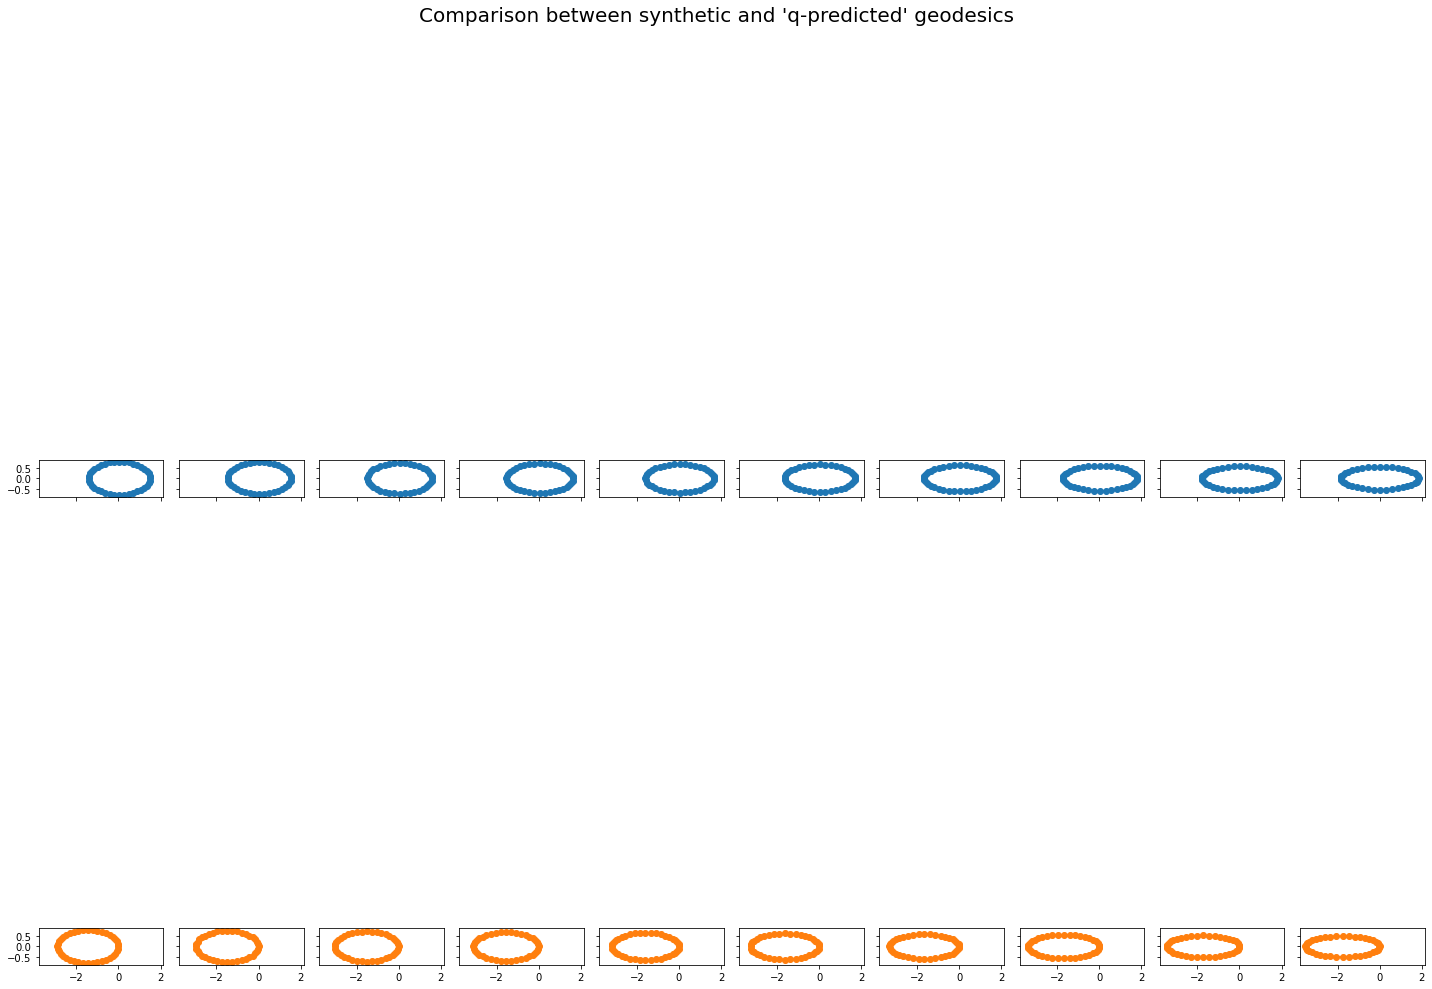

In [294]:
#first, i will create a new array, where one of the geodesics is the original geodesic and the other geodesic
#is the predicted geodesic.

geodesic_array= np.array([geods_circle_ell[0,half_n_times:],predicted_curves])

import matplotlib.pyplot as plt

n_geodesics=2
fig, axes = plt.subplots(
    n_geodesics, half_n_times, figsize=(20,10), sharex=True, sharey=True
)
fig.suptitle("Comparison between synthetic and 'q-predicted' geodesics", fontsize=20)

for i_geodesic in range(n_geodesics):
    curve = geodesic_array[i_geodesic]
    for i_time in range(half_n_times):
        axes[i_geodesic, i_time].plot(
            curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
        )
        axes[i_geodesic, i_time].set_aspect("equal")
plt.tight_layout()

# 3. Creating functions that do everything above in one function

In [141]:
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs


from geomstats.geometry.discrete_curves import ElasticMetric
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import torch
import matplotlib.pyplot as plt
#load discrete curves and R2 manifolds
from geomstats.geometry.discrete_curves import DiscreteCurves, R2


def plot_full_compare_ft(#n_times,
                    geodesic,a,b):
    #import dyn.dyn.datasets.synthetic as synthetic

    n_geodesics = 1
    n_times = len(geodesic)
    print(n_times)
    n_points = len(geodesic[0])

    #creating our synthetic dataset
    #geods_square_rect = synthetic.geodesics_square_to_rectangle(
    #    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points)
    
    # this is creating (aka "instantiating") an object elastic_metric of the class ElasticMetric
    elastic_metric = ElasticMetric(a, b, ambient_manifold=R2)  

    #selecting the first (and only) geodesic
    #geodesic = geods_square_rect[0]

    #q_tensor = elastic_metric.f_transform(geods_square_rect[0])
    q_tensor = elastic_metric.f_transform(geodesic)

    q=np.array(q_tensor)

    #reshape q into a compressed vector
    q_vector = q.reshape((n_times, -1))

    #create regression object
    regr = linear_model.LinearRegression()

    #Now, i need to create an array that only has the times
    q_times_1d = gs.arange(0, n_times, 1)
    q_times = np.reshape(q_times_1d,(10,1))

    regr.fit(q_times,q_vector)

    #compute estimated q predictions
    q_vector_predict=regr.predict(q_times)

    #first, we will have to de-compress the vector (turn it back into its original shape)
    q_array_predict = np.reshape(q_vector_predict,(n_times,n_points-1,2))

    #now, we will transform the array back into a tensor so that f_transoform_inverse will accept it
    q_tensor_predict= torch.from_numpy(q_array_predict)

    starting_point_array = gs.zeros((n_times, 2))

    predicted_curves=elastic_metric.f_transform_inverse(q_tensor_predict,starting_point_array)

    #first, i will create a new array, where one of the geodesics is the original geodesic and the other geodesic
    #is the predicted geodesic.
    
    
    #For plotting reasons, we create a new array from the original geodesic, 
    #where the starting point is zero for each shape.
    recentered_geodesic = gs.zeros([n_times,n_points,2])
    
    for i_time in range(n_times):
        distance_x = geodesic[i_time,0,0]
        distance_y = geodesic[i_time,0,1]
        for i_point in range(n_points):
            recentered_geodesic[i_time,i_point,0]=geodesic[i_time,i_point,0]-distance_x
            recentered_geodesic[i_time,i_point,1]=geodesic[i_time,i_point,1]-distance_y
    
    

    ##geodesic_array= np.array([geods_square_rect[0],predicted_curves])
    geodesic_array= np.array([recentered_geodesic,predicted_curves])
    

    n_geodesics_plot=2
    #n_geodesics_plot=3
    fig, axes = plt.subplots(
        n_geodesics_plot+1, n_times, figsize=(20, 10), sharex=True, sharey=True
    )
    fig.suptitle("Comparison between synthetic and 'q-predicted' geodesics: last plot- (1) and (2) overlaid", fontsize=20)

    for i_geodesic in range(n_geodesics_plot):
        curve = geodesic_array[i_geodesic]
        for i_time in range(n_times):
            axes[i_geodesic, i_time].plot(
                curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
            )
            axes[i_geodesic, i_time].set_aspect("equal")
            
    #now, creating the third set of plots, where they are overlaid
    for i_geodesic in range(n_geodesics_plot):
        curve = geodesic_array[i_geodesic]
        for i_time in range(n_times):
            axes[2, i_time].plot(
                curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
            )
            axes[i_geodesic, i_time].set_aspect("equal")
    
    plt.tight_layout()

10
10


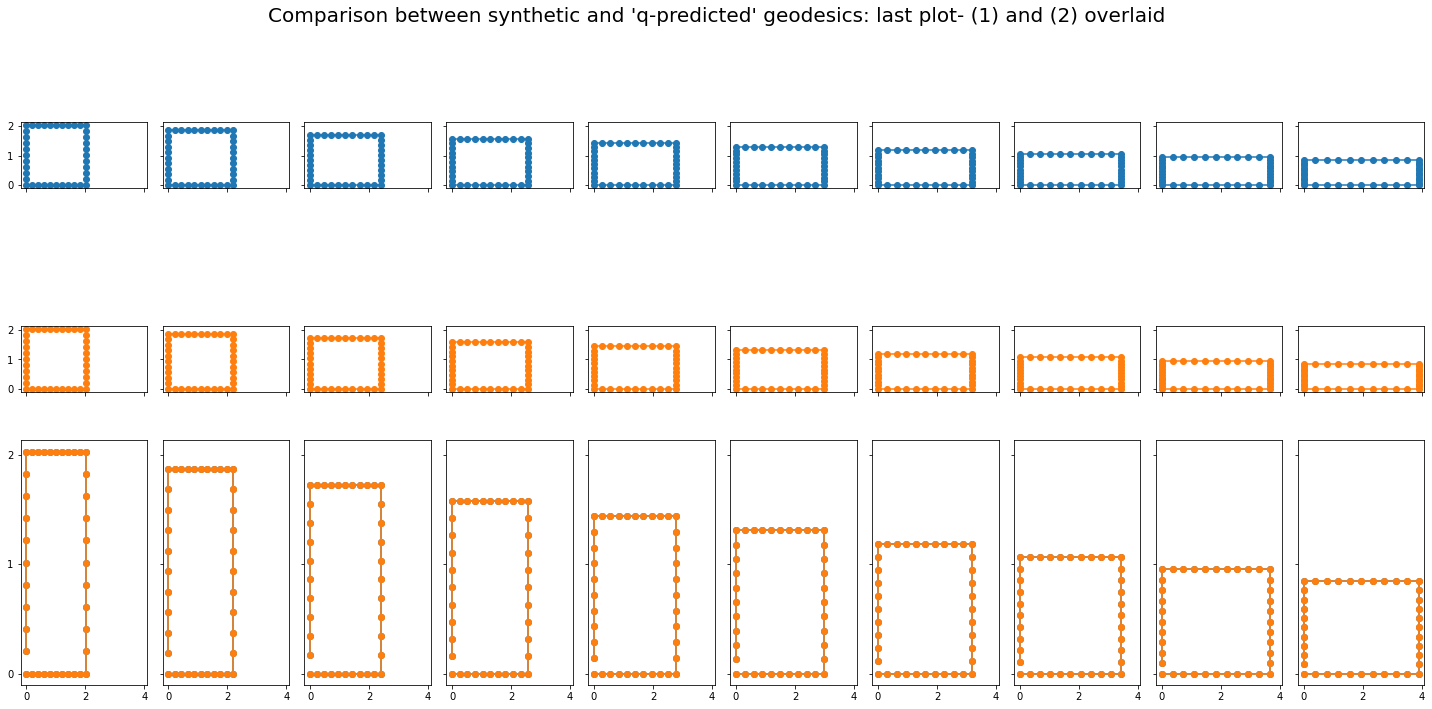

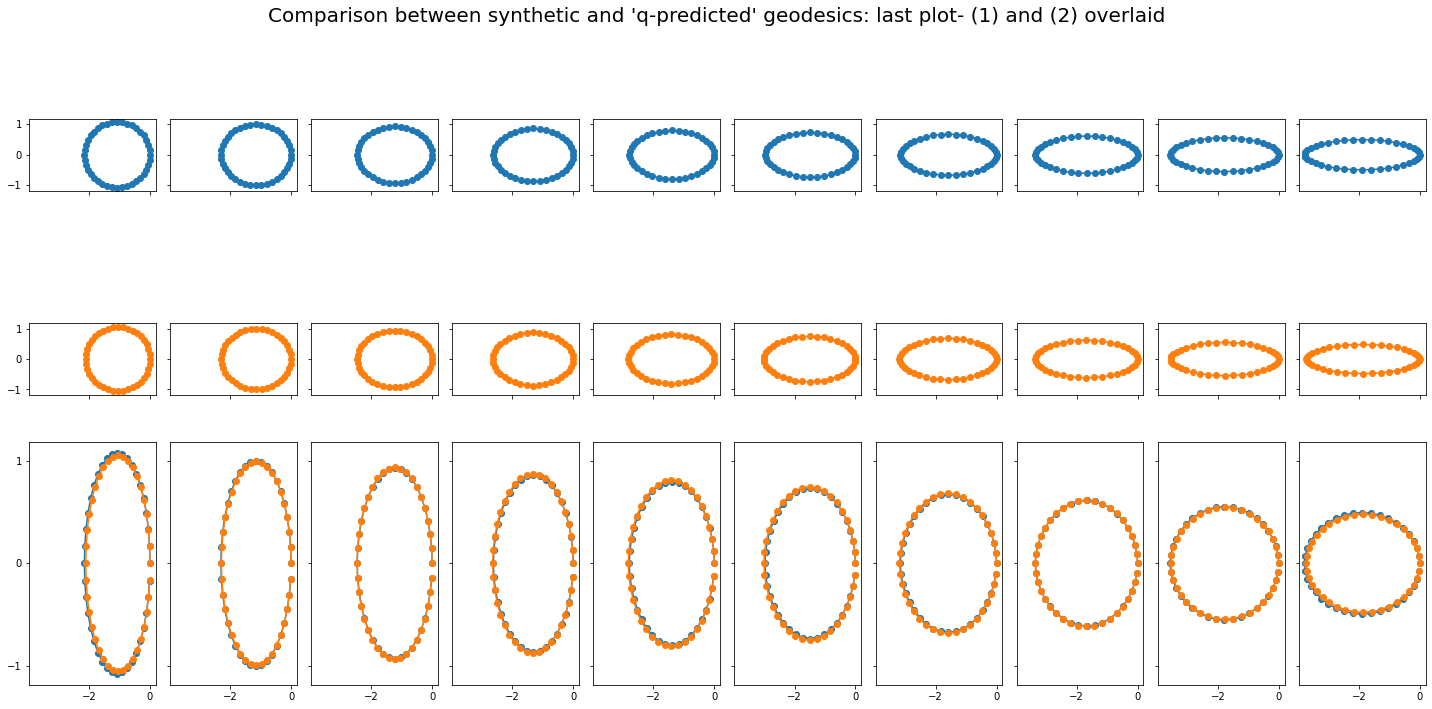

In [95]:
import dyn.dyn.datasets.synthetic as synthetic

n_geodesics = 1
n_times = 10
n_points = 40

#creating our synthetic dataset
geods_square_rect = synthetic.geodesics_square_to_rectangle(
    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
)


plot_full_compare_ft(#n_times,
                geods_square_rect[0],1,1)

#now with the circle
geods_circle_ell = synthetic.geodesics_circle_to_ellipse(
    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
)

plot_full_compare_ft(geods_circle_ell[0],1,1)

In [140]:
from geomstats.geometry.discrete_curves import ElasticMetric
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import torch
import matplotlib.pyplot as plt

import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

#load discrete curves and R2 manifolds
from geomstats.geometry.discrete_curves import DiscreteCurves, R2

def plot_full_compare_ft_split_set(geodesic,a,b):
    #import dyn.dyn.datasets.synthetic as synthetic
    
    #n_times is an int
    #geodesic is the geodesic you want analyzed. This should be a tensor of shape (n_times,n_points,2)
    #"2" because we are considering 2D curves, so the data should be a set of (x,y) points.
    #a and b are the elastic metric parameters.

    n_geodesics = 1
    n_times = len(geodesic)
    n_points = len(geodesic[0])

    #creating our synthetic dataset
    #geods_circle_ell = synthetic.geodesics_circle_to_ellipse(
    #    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
    #)

    # this is creating (aka "instantiating") an object elastic_metric of the class ElasticMetric
    elastic_metric = ElasticMetric(a, b, ambient_manifold=R2)  

    #selecting the first (and only) geodesic
    #geodesic = geods_square_rect[0]

    ##q_tensor = elastic_metric.f_transform(geods_circle_ell[0])
    q_tensor = elastic_metric.f_transform(geodesic)

    q=np.array(q_tensor)

    #reshape q into a compressed vector
    q_vector = q.reshape((n_times, -1))

    #create regression object
    regr = linear_model.LinearRegression()

    #Now, i need to create an array that only has the times
    q_times_1d = gs.arange(0, n_times, 1)

    half_n_times = int(n_times/2)

    #NEW HERE: splitting the dataset
    q_times_1d_train = q_times_1d[:half_n_times]
    q_times_1d_test = q_times_1d[half_n_times:]

    #splitting the vector dataset
    q_vector_train= q_vector[:half_n_times]
    q_vector_test = q_vector[half_n_times:]

    q_times_train = np.reshape(q_times_1d_train,(half_n_times,1))
    q_times_test = np.reshape(q_times_1d_test,(half_n_times,1))

    regr.fit(q_times_train,q_vector_train)

    #compute estimated q predictions
    q_vector_predict=regr.predict(q_times_test)

    q_array_predict = np.reshape(q_vector_predict,(half_n_times,n_points-1,2))

    #now, we will transform the array back into a tensor so that f_transoform_inverse will accept it

    q_tensor_predict= torch.from_numpy(q_array_predict)

    #do the transform
    starting_point_array = gs.zeros((half_n_times, 2))

    predicted_curves=elastic_metric.f_transform_inverse(q_tensor_predict,starting_point_array)

    #first, i will create a new array, where one of the geodesics is the original geodesic and the other geodesic
    #is the predicted geodesic. The third figure will show the two curves overlaid on each other.
    
    #This creates a new array from the original geodesic, where the starting point is zero for each shape.
    recentered_geodesic = gs.zeros([n_times,n_points,2])
    
    for i_time in range(n_times):
        distance_x = geodesic[i_time,0,0]
        distance_y = geodesic[i_time,0,1]
        for i_point in range(n_points):
            recentered_geodesic[i_time,i_point,0]=geodesic[i_time,i_point,0]-distance_x
            recentered_geodesic[i_time,i_point,1]=geodesic[i_time,i_point,1]-distance_y
    
    ##geodesic_array= np.array([geods_circle_ell[0,half_n_times:],predicted_curves])
    geodesic_array= np.array([recentered_geodesic[half_n_times:],predicted_curves])

    n_geodesics_plot=2
    fig, axes = plt.subplots(
        n_geodesics_plot+1, half_n_times, figsize=(20,10), sharex=True, sharey=True
    )
    fig.suptitle("Comparison between synthetic and 'q-predicted' geodesics", fontsize=20)
    
    for i_geodesic in range(n_geodesics_plot):
        curve = geodesic_array[i_geodesic]
        for i_time in range(half_n_times):
            axes[i_geodesic, i_time].plot(
                curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
            )
            axes[i_geodesic, i_time].set_aspect("equal")
        
            
    #now, creating the third set of plots, where they are overlaid
    for i_geodesic in range(n_geodesics_plot):
        curve = geodesic_array[i_geodesic]
        for i_time in range(half_n_times):
            axes[2, i_time].plot(
                curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
            )
            axes[i_geodesic, i_time].set_aspect("equal")
    plt.tight_layout()

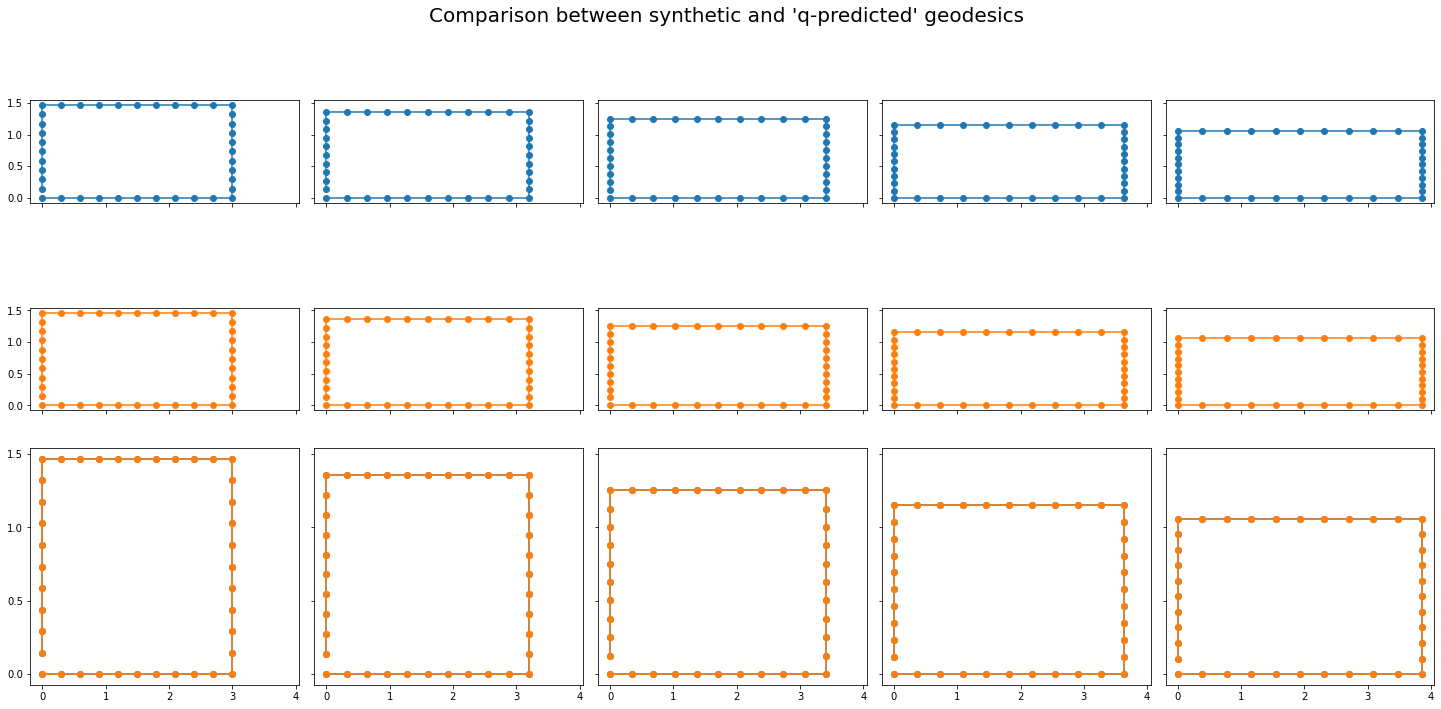

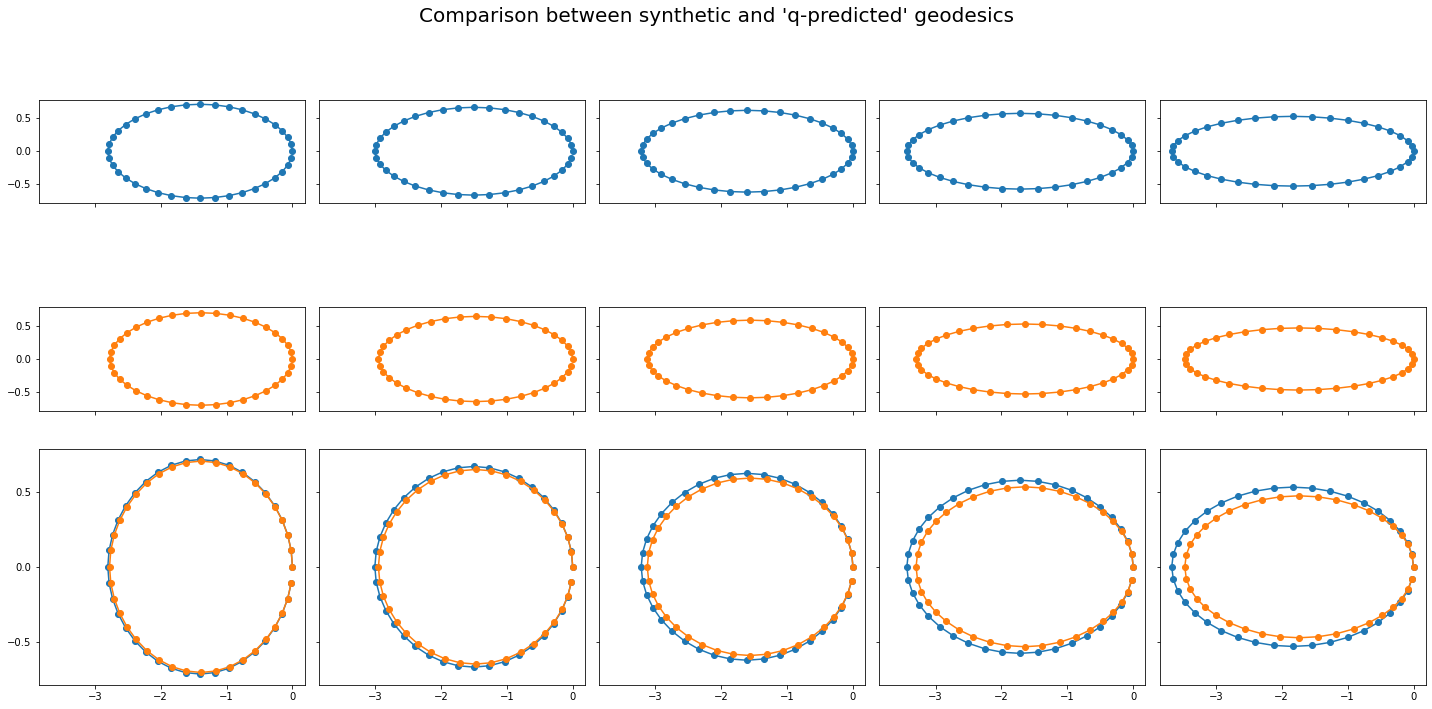

In [105]:
import dyn.dyn.datasets.synthetic as synthetic

n_geodesics = 1
n_times = 10
n_points = 40

#creating our synthetic dataset
geods_square_rect = synthetic.geodesics_square_to_rectangle(
    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
)

plot_full_compare_ft_split_set(geods_square_rect[0],1,1)



#now with the circle
geods_circle_ell = synthetic.geodesics_circle_to_ellipse(
    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
)

plot_full_compare_ft_split_set(geods_circle_ell[0],1,1)

The last two plots show that for a=1, b=1, this method predicts that:
1. the Square to rectangle geodesic "follows a geodesic".
2. The circle to ellipse geodesic does not really follow a geodesic, and this is exasterbated with more extrapolation.

# 4. Functions that only plot the comparison graph

In [139]:
def plot_ft_split_set(geodesic,a,b):
    #import dyn.dyn.datasets.synthetic as synthetic
    
    #n_times is an int
    #geodesic is the geodesic you want analyzed. This should be a tensor of shape (n_times,n_points,2)
    #"2" because we are considering 2D curves, so the data should be a set of (x,y) points.
    #a and b are the elastic metric parameters.

    n_geodesics = 1
    n_times = len(geodesic)
    n_points = len(geodesic[0])

    #creating our synthetic dataset
    #geods_circle_ell = synthetic.geodesics_circle_to_ellipse(
    #    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
    #)

    # this is creating (aka "instantiating") an object elastic_metric of the class ElasticMetric
    elastic_metric = ElasticMetric(a, b, ambient_manifold=R2)  

    #selecting the first (and only) geodesic
    #geodesic = geods_square_rect[0]

    ##q_tensor = elastic_metric.f_transform(geods_circle_ell[0])
    q_tensor = elastic_metric.f_transform(geodesic)

    q=np.array(q_tensor)

    #reshape q into a compressed vector
    q_vector = q.reshape((n_times, -1))

    #create regression object
    regr = linear_model.LinearRegression()

    #Now, i need to create an array that only has the times
    q_times_1d = gs.arange(0, n_times, 1)

    half_n_times = int(n_times/2)

    #NEW HERE: splitting the dataset
    q_times_1d_train = q_times_1d[:half_n_times]
    q_times_1d_test = q_times_1d[half_n_times:]

    #splitting the vector dataset
    q_vector_train= q_vector[:half_n_times]
    q_vector_test = q_vector[half_n_times:]

    q_times_train = np.reshape(q_times_1d_train,(half_n_times,1))
    q_times_test = np.reshape(q_times_1d_test,(half_n_times,1))

    regr.fit(q_times_train,q_vector_train)

    #compute estimated q predictions
    q_vector_predict=regr.predict(q_times_test)

    q_array_predict = np.reshape(q_vector_predict,(half_n_times,n_points-1,2))

    #now, we will transform the array back into a tensor so that f_transoform_inverse will accept it

    q_tensor_predict= torch.from_numpy(q_array_predict)

    #do the transform
    starting_point_array = gs.zeros((half_n_times, 2))

    predicted_curves=elastic_metric.f_transform_inverse(q_tensor_predict,starting_point_array)

    #first, i will create a new array, where one of the geodesics is the original geodesic and the other geodesic
    #is the predicted geodesic. The third figure will show the two curves overlaid on each other.
    
    #This creates a new array from the original geodesic, where the starting point is zero for each shape.
    recentered_geodesic = gs.zeros([n_times,n_points,2])
    
    for i_time in range(n_times):
        distance_x = geodesic[i_time,0,0]
        distance_y = geodesic[i_time,0,1]
        for i_point in range(n_points):
            recentered_geodesic[i_time,i_point,0]=geodesic[i_time,i_point,0]-distance_x
            recentered_geodesic[i_time,i_point,1]=geodesic[i_time,i_point,1]-distance_y
    
    ##geodesic_array= np.array([geods_circle_ell[0,half_n_times:],predicted_curves])
    geodesic_array= np.array([recentered_geodesic[half_n_times:],predicted_curves])

    n_geodesics_plot=2
    fig, axes = plt.subplots(
        1, half_n_times, figsize=(20,10), sharex=True, sharey=True
    )
    fig.suptitle("Elastic Metric: a= "+str(a)+", b= " +str(b)+": Comparison between synthetic and 'q-predicted' geodesics", fontsize=20)
    """
    for i_geodesic in range(n_geodesics_plot):
        curve = geodesic_array[i_geodesic]
        for i_time in range(half_n_times):
            axes[i_geodesic, i_time].plot(
                curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
            )
            axes[i_geodesic, i_time].set_aspect("equal")
    """
            
    #now, creating the third set of plots, where they are overlaid
    for i_geodesic in range(n_geodesics_plot):
        curve = geodesic_array[i_geodesic]
        for i_time in range(half_n_times):
            axes[#2,
                 i_time].plot(
                curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
            )
            axes[#i_geodesic,
                i_time].set_aspect("equal")
    plt.tight_layout()

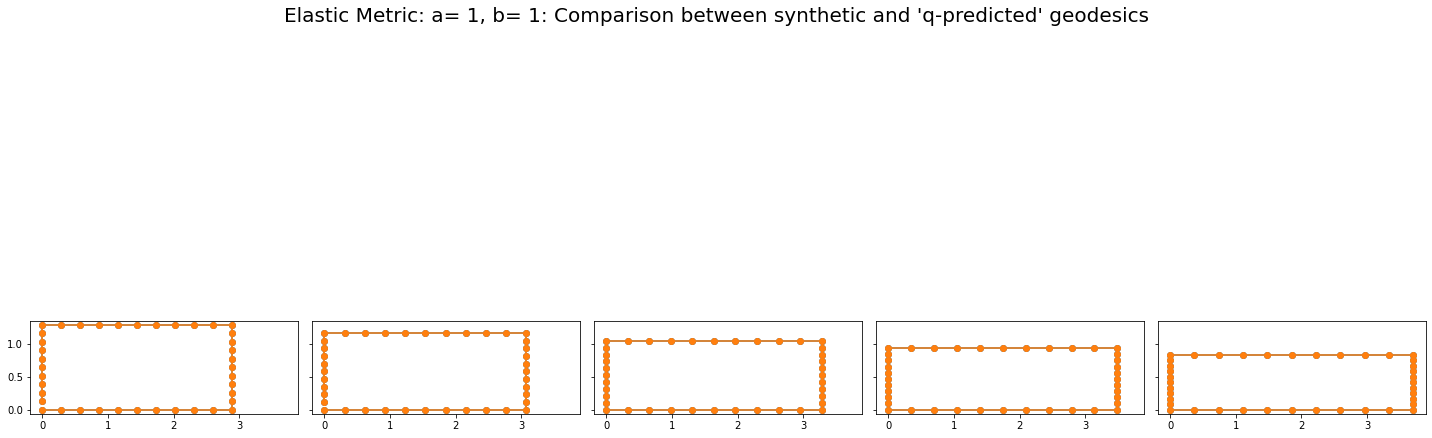

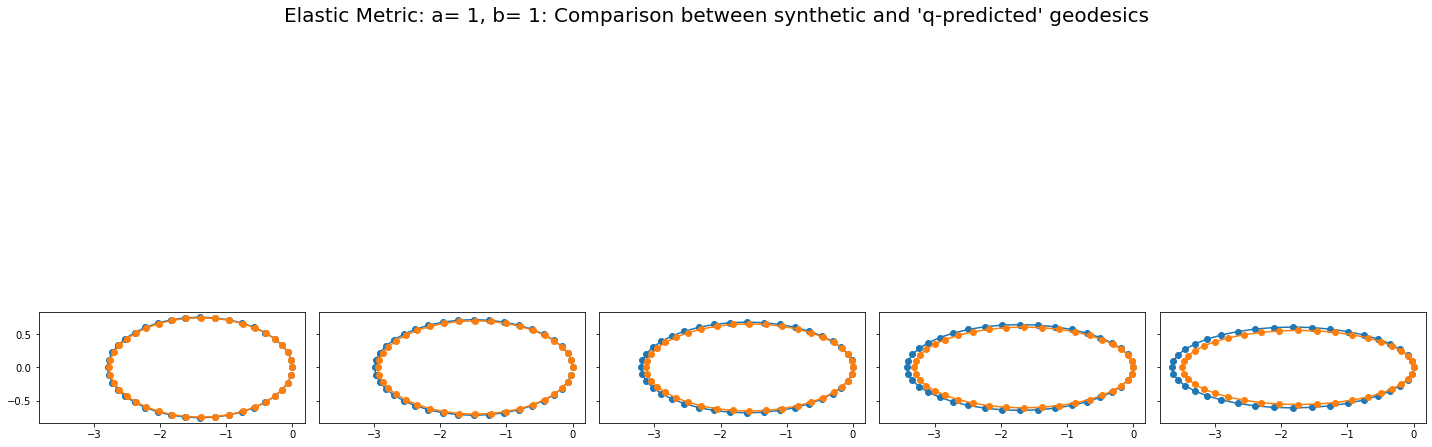

In [133]:
#creating our synthetic dataset
geods_square_rect = synthetic.geodesics_square_to_rectangle(
    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
)

#now with the circle
geods_circle_ell = synthetic.geodesics_circle_to_ellipse(
    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points)

plot_ft_split_set(geods_square_rect[0],1,1)
plot_ft_split_set(geods_circle_ell[0],1,1)

# 5. Experiementing with different values of a and b

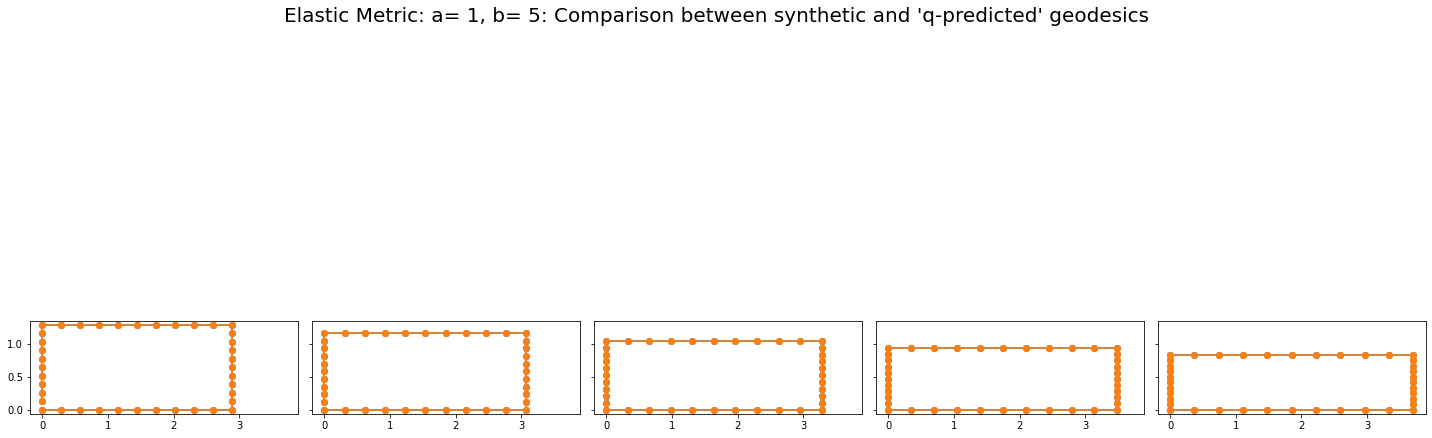

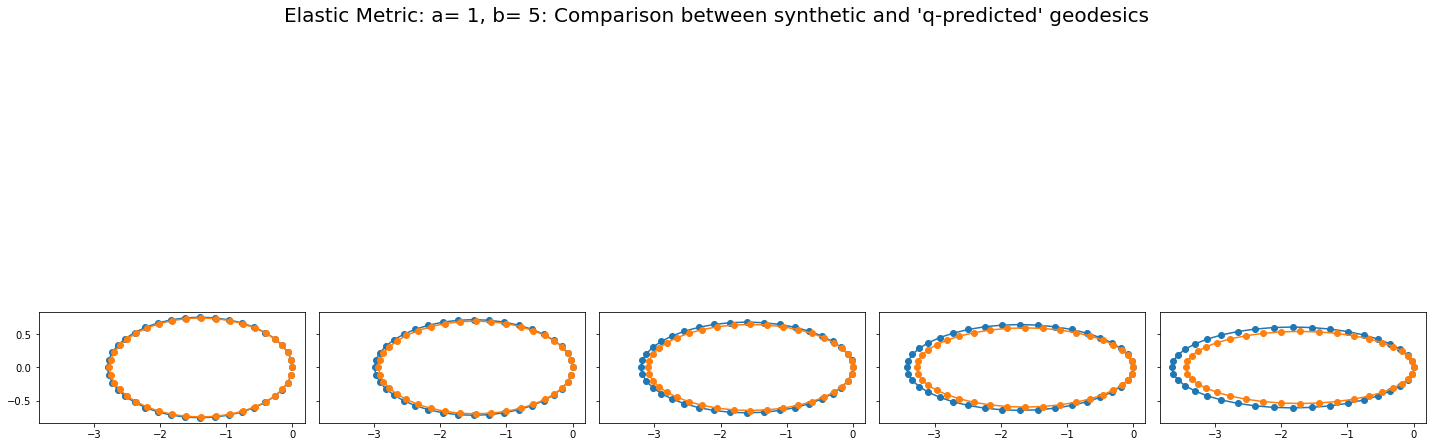

In [134]:
plot_ft_split_set(geods_square_rect[0],1,5)
plot_ft_split_set(geods_circle_ell[0],1,5)

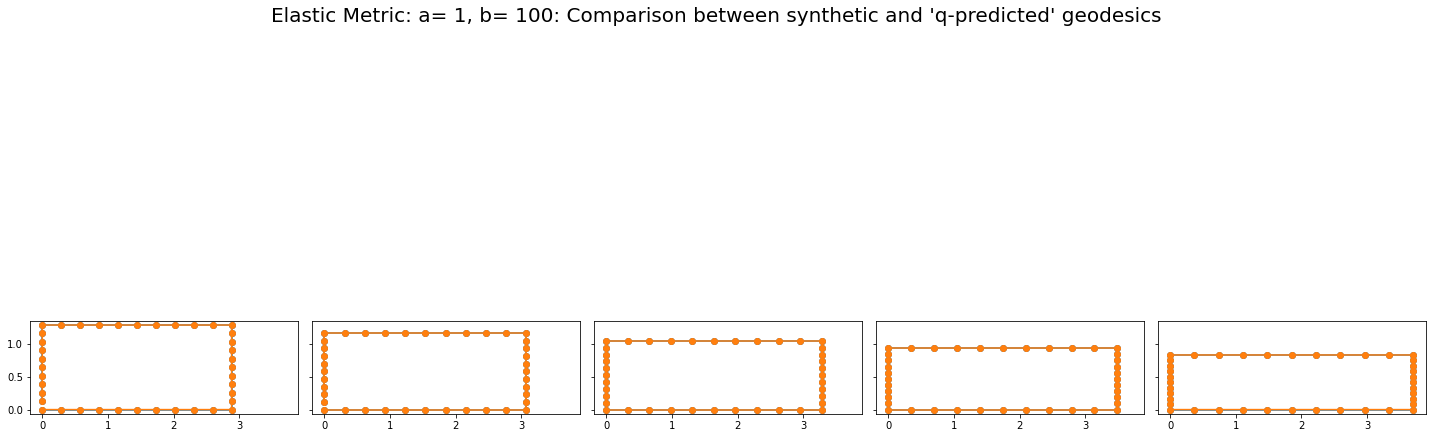

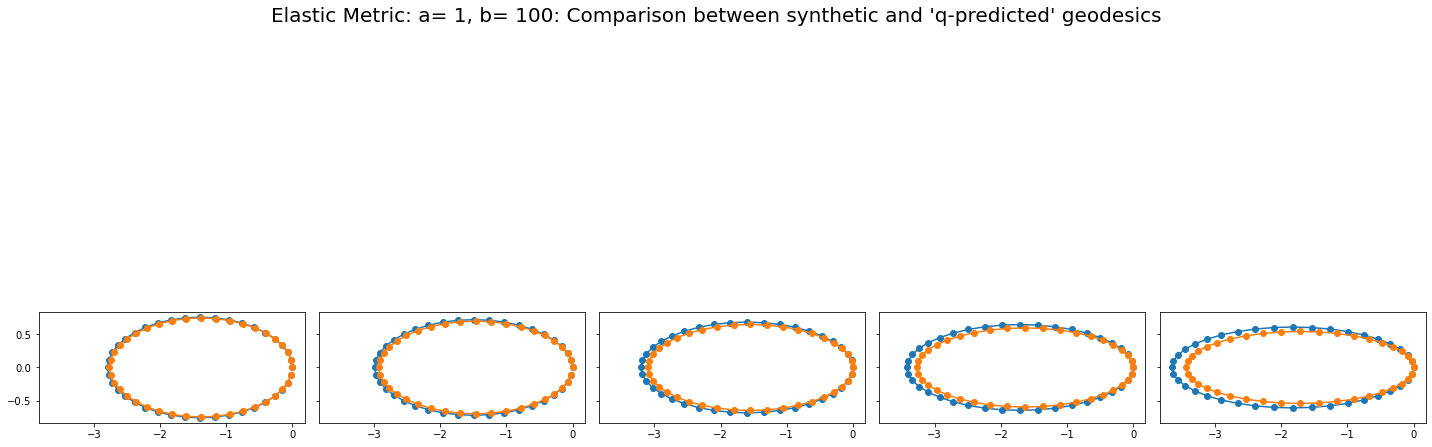

In [135]:
plot_ft_split_set(geods_square_rect[0],1,100)
plot_ft_split_set(geods_circle_ell[0],1,100)

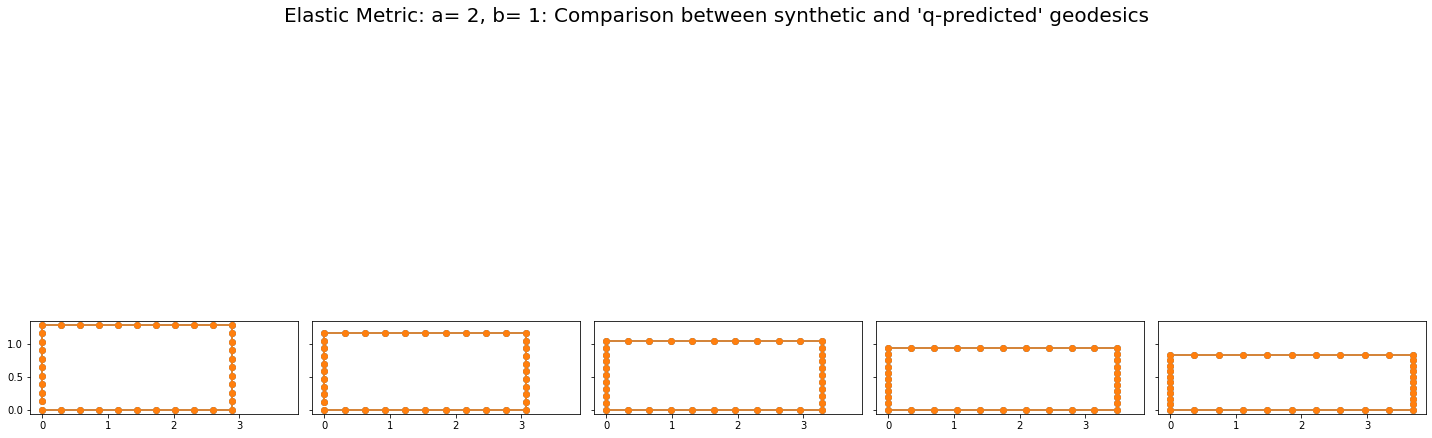

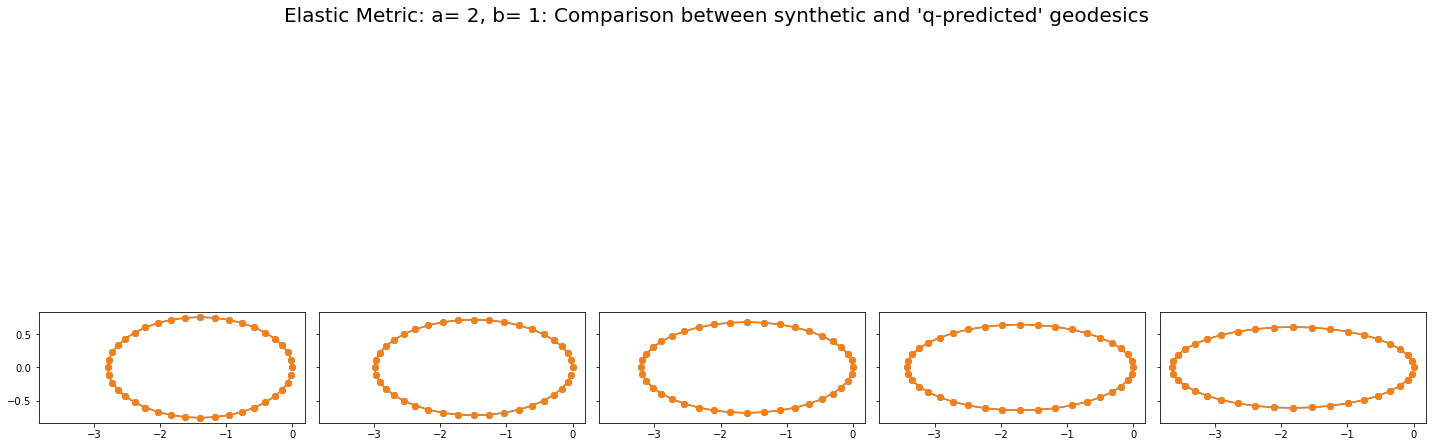

In [137]:
plot_ft_split_set(geods_square_rect[0],2,1)
plot_ft_split_set(geods_circle_ell[0],2,1)

we think that a=2, b=1 fits because that is the metric used to CREATE the geodesic!!! 😮

this could have something to do with "metric learning"!!!! (because we see that when we use the correct parameters, then the predicted geodesic matches the "true" data)

square is flat everywhere, so there is no notion of bending, and that is why the square is fit with all of these parameters

einstien learned the geometry and gave interpretation to it.. here we could learn more geometry!